In [105]:
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller
from scipy.optimize import minimize
import pandas as pd
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.api import VAR
import statsmodels.api as sm
from statsmodels.tsa.statespace.mlemodel import MLEModel
import matplotlib.pyplot as plt
import numpy as np

# 1. ADATOK ELŐKÉSZÍTÉSE

In [106]:
file_path = 'NS_adatok_cln.xlsx'
df = pd.read_excel(file_path)
if 'DATE' in df.columns:
    df['DATE'] = pd.to_datetime(df['DATE'])
    df.set_index('DATE', inplace=True)

yield_cols = ['M0.033', 'M1', 'M3', 'M6', 'M12', 'M36', 'M60', 'M120', 'M180']
maturities = [0.033, 1, 3, 6, 12, 36, 60, 120, 180]
maturities_years = np.array([0.033, 1, 3, 6, 12, 36, 60, 120, 180]) / 12
yields_data = df[yield_cols]


gdp_log = np.log(df['GDP'])
cycle, trend = sm.tsa.filters.hpfilter(gdp_log, lamb=1600)
df['Output_Gap'] = cycle * 100

# Egyéb változók
df['Exchange_Rate_Chg'] = np.log(df['Árfolyam']).diff() * 100
df['Base_Rate'] = df['Kamat']
df['Inflation'] = df['Infláció']


# 2. PCA FUTTATÁSA

In [107]:
pca = PCA(n_components=3)
pca.fit(yields_data)

explained_variance = pca.explained_variance_ratio_

print("\n=== PCA EREDMÉNYEK (Magyarázóerő) ===")
print(f"1. Komponens (Level):     {explained_variance[0]*100:.2f}%")
print(f"2. Komponens (Slope):     {explained_variance[1]*100:.2f}%")
print(f"3. Komponens (Curvature): {explained_variance[2]*100:.2f}%")
print("-" * 30)
print(f"Összesített magyarázóerő: {sum(explained_variance)*100:.2f}%")


=== PCA EREDMÉNYEK (Magyarázóerő) ===
1. Komponens (Level):     97.05%
2. Komponens (Slope):     2.65%
3. Komponens (Curvature): 0.22%
------------------------------
Összesített magyarázóerő: 99.92%


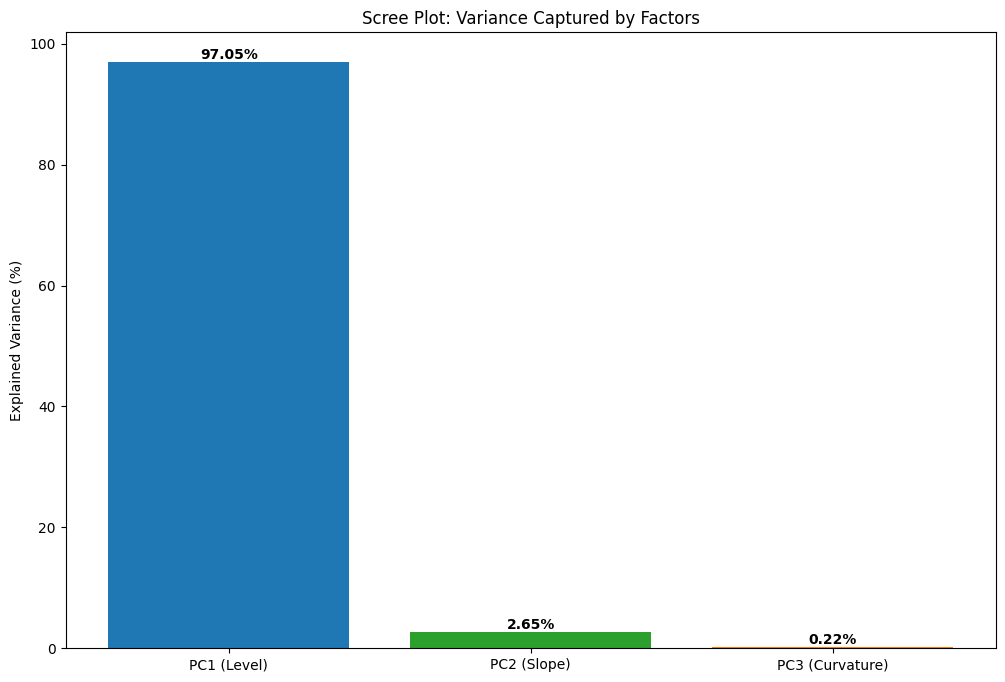

In [108]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'maturities' is a list of the tenors (e.g., [1, 3, 6, 12, ...])
# and 'pca' is your fitted PCA object.

# 1. Plotting Explained Variance (Scree Plot)
plt.figure(figsize=(12, 8))
components = ['PC1 (Level)', 'PC2 (Slope)', 'PC3 (Curvature)']
plt.bar(components, explained_variance * 100, color=['#1f77b4', '#2ca02c', '#ff7f0e'])
plt.ylabel('Explained Variance (%)')
plt.title('Scree Plot: Variance Captured by Factors')

# Adding percentage labels on top of bars
for i, v in enumerate(explained_variance):
    plt.text(i, v*100 + 0.5, f"{v*100:.2f}%", ha='center', fontweight='bold')

plt.show()

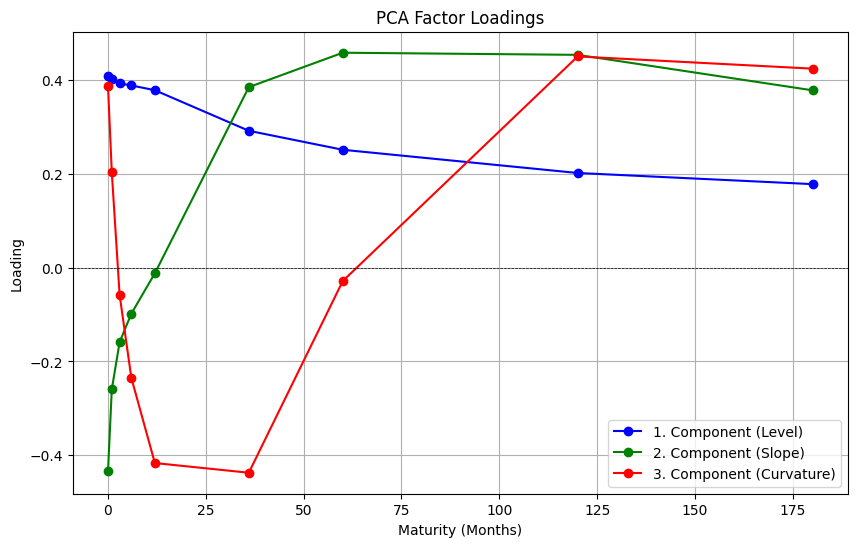

In [109]:
components = pca.components_

plt.figure(figsize=(10, 6))
plt.plot(maturities, components[0], marker='o', label='1. Component (Level)', color='blue')
plt.plot(maturities, components[1], marker='o', label='2. Component (Slope)', color='green')
plt.plot(maturities, components[2], marker='o', label='3. Component (Curvature)', color='red')

plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.title('PCA Factor Loadings')
plt.xlabel('Maturity (Months)')
plt.ylabel('Loading')
plt.legend()
plt.grid(True)
plt.show()

# konkrét érték minden időpontra
pca_factors = pca.transform(yields_data)
pca_df = pd.DataFrame(pca_factors, columns=['Level_PCA', 'Slope_PCA', 'Curvature_PCA'], index=df.index)


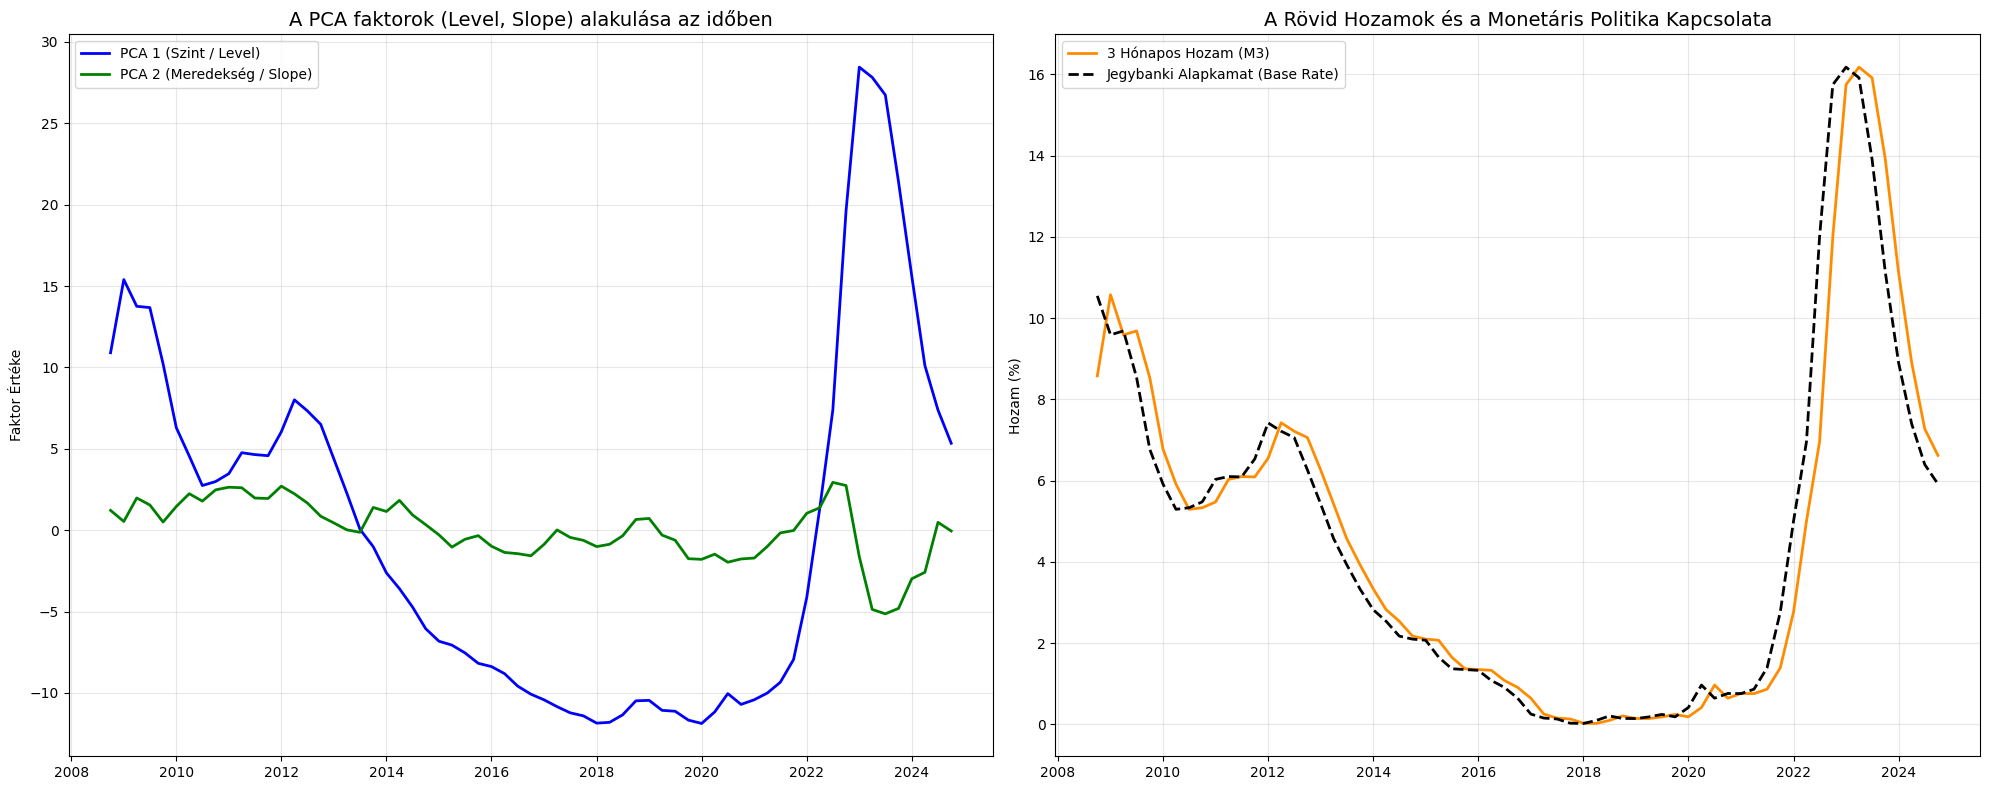

In [110]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

axes[0].plot(pca_df['Level_PCA'], label='PCA 1 (Szint / Level)', color='blue', linewidth=2)
axes[0].plot(pca_df['Slope_PCA'], label='PCA 2 (Meredekség / Slope)', color='green', linewidth=2)

axes[0].set_title('A PCA faktorok (Level, Slope) alakulása az időben', fontsize=14)
axes[0].set_ylabel('Faktor Értéke')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(df.index, df['M3'], label='3 Hónapos Hozam (M3)', color='darkorange', linewidth=2)
axes[1].plot(df.index, df['Kamat'], label='Jegybanki Alapkamat (Base Rate)', color='black', linestyle='--', linewidth=2)

axes[1].set_title('A Rövid Hozamok és a Monetáris Politika Kapcsolata', fontsize=14)
axes[1].set_ylabel('Hozam (%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# NELSON-SIEGEL FAKTOROK BECSLÉSE

# A Nelson-Siegel Modell Matematikai Levezetése és Becslése

Ebben a részben a hozamgörbe ($y_t(\tau)$) felbontását végeztük el látens (nem megfigyelhető) faktorokra a **Nelson-Siegel (1987)** keretrendszer segítségével.

## 1. A Nelson-Siegel Egyenlet

A modell alapfeltevése, hogy a $t$ időpontban a $\tau$ lejárathoz tartozó azonnali (spot) hozam három komponens lineáris kombinációjaként áll elő:

$$
y_t(\tau) = L_t + S_t \left( \frac{1 - e^{-\lambda \tau}}{\lambda \tau} \right) + C_t \left( \frac{1 - e^{-\lambda \tau}}{\lambda \tau} - e^{-\lambda \tau} \right) + \varepsilon_t(\tau)
$$

Ahol:
* $y_t(\tau)$: A megfigyelt hozam a $t$ időpontban $\tau$ lejárra.
* $\lambda$: A lecsengési paraméter (decay parameter), amely a görbület helyét határozza meg.
* **A látens faktorok:**
    * $L_t$ (**Level**): Hosszú távú kamatszint (a hozamgörbe szintje).
    * $S_t$ (**Slope**): A hozamgörbe meredeksége (rövid távú - hosszú távú hozam).
    * $C_t$ (**Curvature**): A hozamgörbe görbülete (púpja).

### Gazdasági Interpretáció (Határértékek)
A matematikai határértékek igazolják a faktorok elnevezését:
* **Level:** $\lim_{\tau \to \infty} y_t(\tau) = L_t$ (mivel a többi tag 0-hoz tart).
* **Slope:** $\lim_{\tau \to 0} y_t(\tau) = L_t + S_t$. Tehát a rövid hozam $L+S$, a hosszú hozam $L$, a különbségük (meredekség) pedig $-S_t$.

## 2. A Becslési Eljárás (Kétlépcsős Módszer)

Mivel a $\lambda$ paraméter nem-lineárisan szerepel az egyenletben, a becslést nem tudjuk egyetlen egyszerű lineáris regresszióval elvégezni. Ezért a **Diebold-Li (2006)** féle kétlépcsős eljárást (vagy annak iteratív optimalizálását) alkalmaztuk.

### A) A Regresszorok (Loadings) Előállítása
Rögzített $\lambda$ mellett a faktorokhoz tartozó súlyfüggvények (loadings) konstansokká válnak minden $t$ időpontban. Jelölje $X$ a magyarázó változók mátrixát (Design Matrix):

Legyenek a lejáratok: $\tau_1, \tau_2, \dots, \tau_N$. Ekkor az $X$ mátrix:

$$
X = \begin{bmatrix}
1 & \frac{1 - e^{-\lambda \tau_1}}{\lambda \tau_1} & \frac{1 - e^{-\lambda \tau_1}}{\lambda \tau_1} - e^{-\lambda \tau_1} \\
1 & \frac{1 - e^{-\lambda \tau_2}}{\lambda \tau_2} & \frac{1 - e^{-\lambda \tau_2}}{\lambda \tau_2} - e^{-\lambda \tau_2} \\
\vdots & \vdots & \vdots \\
1 & \frac{1 - e^{-\lambda \tau_N}}{\lambda \tau_N} & \frac{1 - e^{-\lambda \tau_N}}{\lambda \tau_N} - e^{-\lambda \tau_N}
\end{bmatrix}
$$

### B) Lineáris Regresszió (OLS) minden időpontra
Minden egyes $t$ időpontban rendelkezésre áll a hozamok vektora $Y_t = [y_t(\tau_1), \dots, y_t(\tau_N)]^T$.
A keresett faktorok vektora: $\beta_t = [L_t, S_t, C_t]^T$.

A becsülendő egyenlet mátrix formában:
$$
Y_t = X \beta_t + \varepsilon_t
$$

Mivel $X$ ismert (fix $\lambda$ mellett), a faktorok becslése a **Legkisebb Négyzetek Módszerével (OLS)** történik:

$$
\hat{\beta}_t = (X^T X)^{-1} X^T Y_t
$$

Ezt a lépést a Python kódunk a `LinearRegression` függvénnyel végezte el minden egyes dátumra.

### C) A Lambda ($\lambda$) Optimalizálása
Hogy megtaláljuk a legjobb $\lambda$ értéket, egy nem-lineáris optimalizálást (Nelder-Mead algoritmus) futtattunk. A célfüggvény a teljes modell átlagos négyzetes hibájának (RMSE) minimalizálása volt az összes időpontra ($T$) és lejáratra ($N$) nézve:

$$
\min_{\lambda} \sqrt{ \frac{1}{T \cdot N} \sum_{t=1}^{T} \sum_{i=1}^{N} \left( y_t(\tau_i) - \hat{y}_t(\tau_i | \lambda) \right)^2 }
$$

Ahol $\hat{y}_t(\tau_i | \lambda)$ a modell által visszabecsült hozam az adott $\lambda$-val számolt faktorok alapján.

**Eredmény:**
* A 3-faktoros modellhez kapott optimális érték: **$\lambda \approx 0.6056$**
* A Reppa-féle 2-faktoros (C=0) modellhez: **$\lambda \approx 0.5502$**

Lambda optimalizálása...
-> 2-faktoros Lambda: 0.5502
-> 3-faktoros Lambda: 0.6056


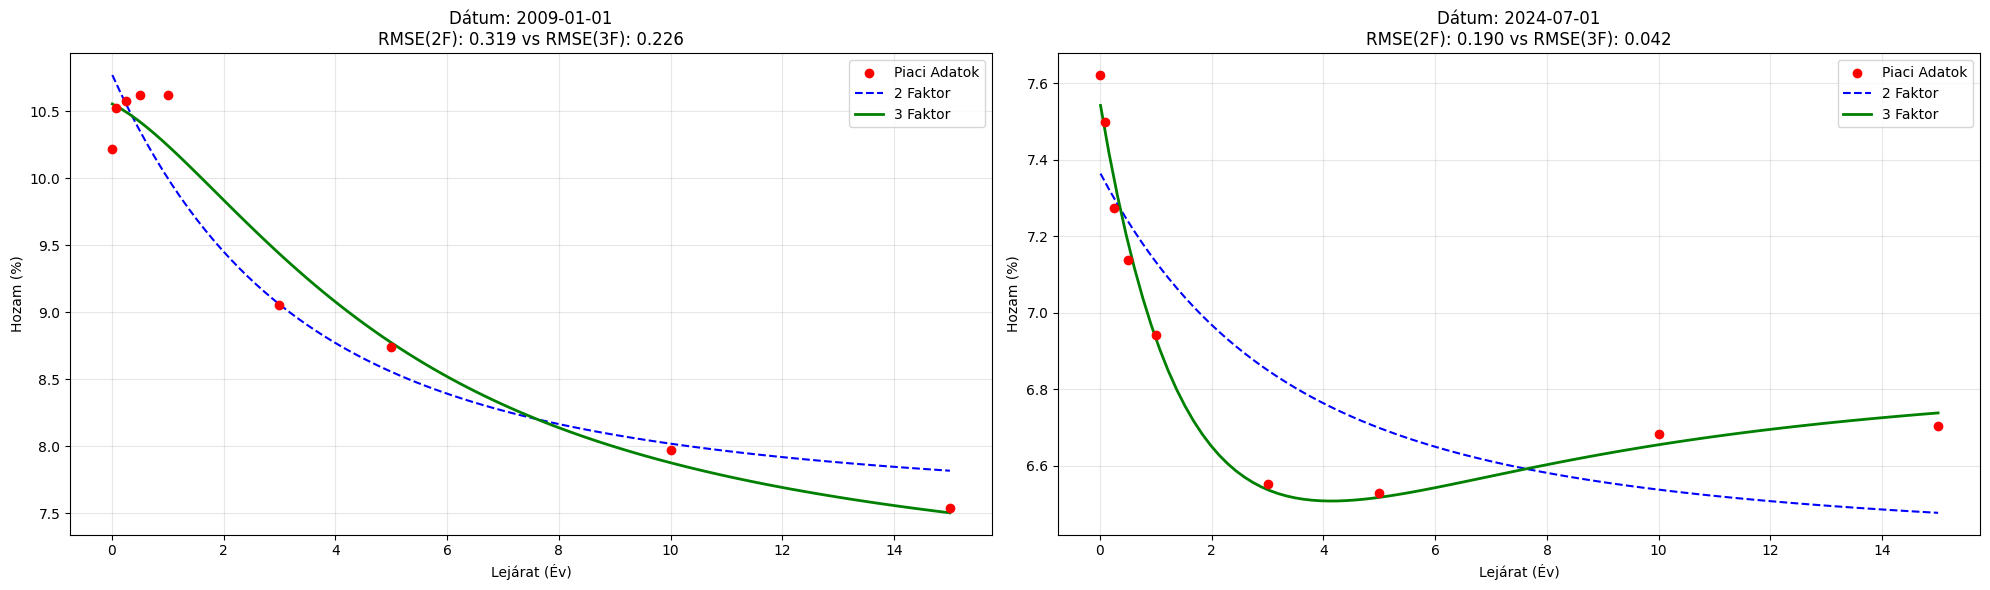

In [111]:
date1 = '2009-01-01'
date2 = '2024-07-01'

def ns_loadings_2factor(tau, lam):
    col_level = np.ones_like(tau)
    col_slope = (1 - np.exp(-lam * tau)) / (lam * tau)
    return np.column_stack((col_level, col_slope))

def ns_loadings_3factor(tau, lam):
    col_level = np.ones_like(tau)
    col_slope = (1 - np.exp(-lam * tau)) / (lam * tau)
    col_curv = col_slope - np.exp(-lam * tau)
    return np.column_stack((col_level, col_slope, col_curv))

def get_rmse_generic(lam, y_data, tau, model_func):
    if lam <= 0: return 1e10
    X = model_func(tau, lam)
    try:
        beta = np.linalg.pinv(X) @ y_data.values.T
        y_pred = (X @ beta).T
        return np.sqrt(np.mean((y_data.values - y_pred)**2))
    except:
        return 1e10

print("Lambda optimalizálása...")
res_2f = minimize(get_rmse_generic, x0=0.7, args=(yields_data, maturities_years, ns_loadings_2factor), method='Nelder-Mead')
opt_lambda_2f = res_2f.x[0]
res_3f = minimize(get_rmse_generic, x0=0.7, args=(yields_data, maturities_years, ns_loadings_3factor), method='Nelder-Mead')
opt_lambda_3f = res_3f.x[0]

print(f"-> 2-faktoros Lambda: {opt_lambda_2f:.4f}")
print(f"-> 3-faktoros Lambda: {opt_lambda_3f:.4f}")

def plot_ns_fit(ax, date, y_data_all, tau, lam2, lam3):
    if date not in y_data_all.index:
        date = y_data_all.index[0]

    actuals = y_data_all.loc[date].values

    # 2 Faktoros Illesztés
    X2 = ns_loadings_2factor(tau, lam2)
    reg2 = LinearRegression(fit_intercept=False).fit(X2, actuals)

    # 3 Faktoros Illesztés
    X3 = ns_loadings_3factor(tau, lam3)
    reg3 = LinearRegression(fit_intercept=False).fit(X3, actuals)

    # Görbék generálása
    tau_smooth = np.linspace(0.01, 15, 100)
    curve2 = reg2.predict(ns_loadings_2factor(tau_smooth, lam2))
    curve3 = reg3.predict(ns_loadings_3factor(tau_smooth, lam3))

    # Plotolás
    ax.scatter(tau, actuals, color='red', label='Piaci Adatok', zorder=5)
    ax.plot(tau_smooth, curve2, label=f'2 Faktor', color='blue', linestyle='--')
    ax.plot(tau_smooth, curve3, label=f'3 Faktor', color='green', linewidth=2)

    rmse2 = np.sqrt(np.mean((actuals - reg2.predict(X2))**2))
    rmse3 = np.sqrt(np.mean((actuals - reg3.predict(X3))**2))

    ax.set_title(f'Dátum: {str(date)[:10]}\nRMSE(2F): {rmse2:.3f} vs RMSE(3F): {rmse3:.3f}')
    ax.set_xlabel('Lejárat (Év)')
    ax.set_ylabel('Hozam (%)')
    ax.legend()
    ax.grid(True, alpha=0.3)

fig, axes = plt.subplots(1, 2, figsize=(20, 6))
plot_ns_fit(axes[0], date1, yields_data, maturities_years, opt_lambda_2f, opt_lambda_3f)
plot_ns_fit(axes[1], date2, yields_data, maturities_years, opt_lambda_2f, opt_lambda_3f)

plt.tight_layout()
#plt.savefig('ns_comparison_2dates.png')
plt.show()


## STACIONARITÁS VIZSGÁLAT (ADF TESZT)

In [112]:
X_3f = ns_loadings_3factor(maturities_years, opt_lambda_3f)
ns_factors_3f = []

for index, row in yields_data.iterrows():
    reg = LinearRegression(fit_intercept=False).fit(X_3f, row.values)
    ns_factors_3f.append(reg.coef_)

ns_df_3f = pd.DataFrame(ns_factors_3f, columns=['Level_NS', 'Slope_NS', 'Curvature_NS'], index=df.index)
var_data_3f = pd.concat([
    ns_df_3f[['Level_NS', 'Slope_NS', 'Curvature_NS']],
    df[['Base_Rate', 'Inflation', 'Output_Gap', 'Exchange_Rate_Chg']]
], axis=1).dropna()

print("\n=== Stacionaritás Vizsgálat (ADF) a 3-Faktoros Modellel ===")
print(f"{'Változó':<20} {'ADF Stat':<10} {'p-érték':<10} {'Eredmény'}")
print("-" * 55)

for col in var_data_3f.columns:
    result = adfuller(var_data_3f[col])
    p_value = result[1]
    if p_value < 0.05:
        verdict = "Stacioner (OK)"
    else:
        verdict = "Nem stacioner (!)"
    print(f"{col:<20} {result[0]:<10.4f} {p_value:<10.4f} {verdict}")


=== Stacionaritás Vizsgálat (ADF) a 3-Faktoros Modellel ===
Változó              ADF Stat   p-érték    Eredmény
-------------------------------------------------------
Level_NS             -1.9703    0.2998     Nem stacioner (!)
Slope_NS             -1.3004    0.6290     Nem stacioner (!)
Curvature_NS         -3.0048    0.0344     Stacioner (OK)
Base_Rate            -1.2654    0.6449     Nem stacioner (!)
Inflation            -0.6489    0.8595     Nem stacioner (!)
Output_Gap           -5.1021    0.0000     Stacioner (OK)
Exchange_Rate_Chg    -6.6604    0.0000     Stacioner (OK)


# VAR model

In [113]:
USE_3_FACTOR_MODEL = False     # True: 3 Faktor (L, S, C), False: 2 Faktor (L, S)

if USE_3_FACTOR_MODEL:
    opt_lambda = 0.6056
    n_factors = 3
    factor_names = ['Level_K', 'Slope_K', 'Curvature_K']
else:
    opt_lambda = 0.5502
    n_factors = 2
    factor_names = ['Level_K', 'Slope_K']


In [114]:
# Válogassuk ki a 4 releváns makrováltozót
macro_cols = ['Output_Gap', 'Inflation', 'Base_Rate', 'Exchange_Rate_Chg']
# Fontos: Csak azokat a sorokat tartsuk meg, ahol minden adat megvan
combined_data = pd.concat([yields_data, df[macro_cols]], axis=1).dropna()

# Frissítsük a yields_data-t és a makro adatokat az új közös indexre
yields_data_sync = combined_data.iloc[:, :9]
macro_data_sync = combined_data.iloc[:, 9:]

In [115]:
print(f"--- MODELL: {'3 FAKTOROS (Kálmán-szűrővel)' if USE_3_FACTOR_MODEL else '2 FAKTOROS (Kálmán-szűrővel)'} ---")

def get_design_matrix(tau, lam, n_fact):
    col_level = np.ones_like(tau)
    col_slope = (1 - np.exp(-lam * tau)) / (lam * tau)
    if n_fact == 3:
        col_curv = col_slope - np.exp(-lam * tau)
        return np.column_stack((col_level, col_slope, col_curv))
    else:
        return np.column_stack((col_level, col_slope))

--- MODELL: 2 FAKTOROS (Kálmán-szűrővel) ---


In [116]:
class NelsonSiegelSSM(MLEModel):
    def __init__(self, endog, maturities, lam, n_fact):
        self.n_macro = 4
        k_states = n_fact + self.n_macro # 6 vagy 7 állapot
        k_endog = endog.shape[1]         # 13 megfigyelés (9 hozam + 4 makro)

        super().__init__(endog, k_states=k_states, k_posdef=k_states, initialization='approximate_diffuse')

        self.maturities = maturities
        self.lam = lam
        self.n_fact = n_fact

        # H mátrix alapbeállítása (k_endog x k_states)
        H = np.zeros((k_endog, k_states))
        ns_loadings = get_design_matrix(maturities, lam, n_fact)
        H[:9, :n_fact] = ns_loadings       # Hozamok -> NS faktorok
        H[9:, n_fact:] = np.eye(self.n_macro) # Makro adatok -> Makro állapotok

        self['design'] = H
        self['selection'] = np.eye(k_states)

    @property
    def param_names(self):
        k_s = self.k_states
        k_e = self.endog.shape[1]
        names = [f'phi_diag_{i}' for i in range(k_s)]
        names += ['OG_to_L', 'Inf_to_L', 'BR_to_L', 'RP_to_L']
        names += ['OG_to_S', 'Inf_to_S', 'BR_to_S', 'RP_to_S']
        names += [f'sigma2_state_{i}' for i in range(k_s)]
        names += [f'sigma2_obs_{i}' for i in range(k_e)]
        names += ['lambda']
        return names

    # JAVÍTÁS: Hozzáadtuk a **kwargs-t a szignatúrához!
    def update(self, params, transformed=True, includes_fixed=False, **kwargs):
        params = super().update(params, transformed, includes_fixed)

        n_s = self.k_states
        n_e = self.endog.shape[1]

        # 1. Átmeneti mátrix (Transition Matrix - T)
        # Diagonális elemek (AR1)
        for i in range(n_s):
            self['transition', i, i] = params[i]

        # Nem-diagonális interakciók (Macro -> Level/Slope)
        # params[n_s : n_s+4] -> Hatás a Level-re (0. index)
        # params[n_s+4 : n_s+8] -> Hatás a Slope-ra (1. index)
        for j in range(self.n_macro):
            self['transition', 0, self.n_fact + j] = params[n_s + j]
            self['transition', 1, self.n_fact + j] = params[n_s + 4 + j]

        # 2. Állapot varianciák (Q mátrix)
        # Itt a varianciákat mindig pozitívnak kell venni (ha transformed=True, a statsmodels kezeli)
        state_vars = params[n_s+8 : 2*n_s+8]
        self['state_cov'] = np.diag(state_vars)

        # 3. Mérési varianciák (R mátrix)
        obs_vars = params[2*n_s+8 : 2*n_s+8+n_e]
        self['obs_cov'] = np.diag(obs_vars)

        # 4. Lambda és a Design mátrix frissítése
        # Ez biztosítja, hogy ha az optimalizáló változtat a lambdán, a görbe alakja is frissüljön
        lmb = params[-1]
        s_loading = (1 - np.exp(-lmb * self.maturities)) / (lmb * self.maturities)
        self['design', :9, 1] = s_loading
        if self.n_fact == 3:
             self['design', :9, 2] = s_loading - np.exp(-lmb * self.maturities)

# =============================================================================
# BECSLÉS INDÍTÁSA
# =============================================================================

# Adatok előkészítése (Ha még nem tetted meg)
macro_cols = ['Output_Gap', 'Inflation', 'Base_Rate', 'Exchange_Rate_Chg']
combined_data = pd.concat([yields_data, df[macro_cols]], axis=1).dropna()

# Start paraméterek precíz hossza:
# n_fact=2 esetén: 6 (phi) + 8 (inter) + 6 (Q) + 13 (R) + 1 (lam) = 34 paraméter
k_s = n_factors + 4
k_e = combined_data.shape[1]

start_params = np.concatenate([
    np.repeat(0.8, k_s),      # phi_diag
    np.repeat(0.0, 8),        # interakciók
    np.repeat(0.01, k_s),     # sigma2_state
    np.repeat(0.1, k_e),      # sigma2_obs
    [opt_lambda]              # lambda
])

mod_kf = NelsonSiegelSSM(combined_data, maturities_years, opt_lambda, n_factors)

# Most már hiba nélkül lefut a fit()
res_kf = mod_kf.fit(start_params=start_params, method='bfgs', maxiter=1000, disp=True)

print("Modell illesztése sikeres!")

         Current function value: 20.379939
         Iterations: 2
         Function evaluations: 57
         Gradient evaluations: 54
Modell illesztése sikeres!


In [117]:
# 1. Adatok szinkronizálása és fűzése (Fontos!)
macro_cols = ['Output_Gap', 'Inflation', 'Base_Rate', 'Exchange_Rate_Chg']
# Az eredeti 'df' és a 'yields_data' közös indexen kell legyen
combined_data = pd.concat([yields_data, df[macro_cols]], axis=1).dropna()

print(f"Kálmán-szűrő futtatása {combined_data.shape[1]} változóval...")

# 2. Start paraméterek felépítése (Hossz: ~36)
k_s = n_factors + 4
k_e = combined_data.shape[1]

# Tippek:
phi_guess = np.repeat(0.85, k_s)      # Magas perzisztencia
inter_guess = np.repeat(0.0, 8)       # 0 kezdeti interakció
state_var_guess = np.repeat(0.05, k_s)
obs_var_guess = np.repeat(0.1, k_e)
lambda_guess = [opt_lambda]

start_params = np.concatenate([phi_guess, inter_guess, state_var_guess, obs_var_guess, lambda_guess])

# 3. Modell indítása a KOMBINÁLT adatokkal
mod_kf = NelsonSiegelSSM(combined_data, maturities_years, opt_lambda, n_factors)

# BFGS optimalizáció (érzékeny a start_params-ra, de pontosabb)
res_kf = mod_kf.fit(start_params=start_params, method='bfgs', maxiter=1000, disp=True)

# 4. Faktorok kinyerése (Csak az első n_factors oszlop a hozamfaktor)
# A smoothed_state mátrixban az állapotok sorrendje: [L, S, (C), Macro1, Macro2...]
kf_factors_raw = res_kf.smoothed_state.T
kf_factors_df = pd.DataFrame(kf_factors_raw[:, :n_factors],
                             columns=factor_names,
                             index=combined_data.index)

print("-> Kálmán-szűrő sikeres!")

Kálmán-szűrő futtatása 13 változóval...
         Current function value: 15.488312
         Iterations: 32
         Function evaluations: 123
         Gradient evaluations: 116
-> Kálmán-szűrő sikeres!


VAR modell építése a Kálmán-faktorokkal...
-> SIKER: A modell stabil!


<Figure size 1200x1000 with 0 Axes>

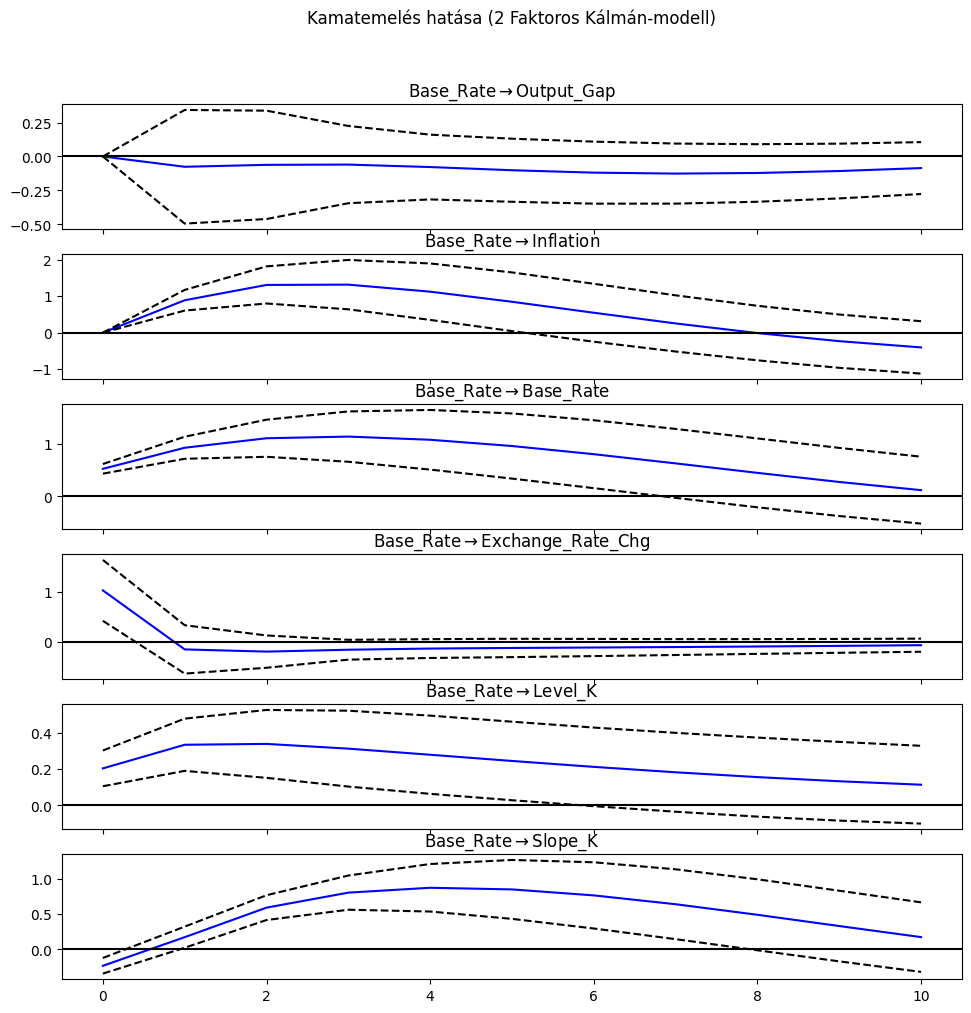


=== Szórásfelbontás: Mi mozgatja a Level_K faktort? ===
FEVD for Output_Gap
     Output_Gap  Inflation  Base_Rate  Exchange_Rate_Chg   Level_K   Slope_K
0      1.000000   0.000000   0.000000           0.000000  0.000000  0.000000
1      0.991785   0.002515   0.001023           0.000048  0.004629  0.000000
2      0.982900   0.004424   0.001661           0.000291  0.010723  0.000000
3      0.976378   0.004877   0.002263           0.000609  0.015872  0.000001
4      0.971528   0.004855   0.003291           0.000754  0.019555  0.000015
5      0.966935   0.005307   0.005032           0.000758  0.021907  0.000059
6      0.961811   0.006619   0.007415           0.000798  0.023218  0.000138
7      0.956222   0.008687   0.010050           0.000993  0.023803  0.000245
8      0.950738   0.011143   0.012459           0.001345  0.023953  0.000362
9      0.946000   0.013559   0.014295           0.001777  0.023898  0.000472

FEVD for Inflation
     Output_Gap  Inflation  Base_Rate  Exchange_Rate_Chg

In [118]:

# =============================================================================
# 5. VÉGSŐ VAR MODELL (MOST MÁR A KÁLMÁN FAKTOROKKAL)
# =============================================================================
print("VAR modell építése a Kálmán-faktorokkal...")

# Makrováltozók (Újra definiáljuk a biztonság kedvéért)
gdp_log = np.log(df['GDP'])
cycle, _ = sm.tsa.filters.hpfilter(gdp_log, lamb=1600)
df['Output_Gap'] = cycle * 100
df['Exchange_Rate_Chg'] = np.log(df['Árfolyam']).diff() * 100
df['Base_Rate'] = df['Kamat']
df['Inflation'] = df['Infláció']

# Adatok összeállítása
# Fontos: A kf_factors_df-et használjuk!
var_data = pd.concat([df[['Output_Gap', 'Inflation', 'Base_Rate', 'Exchange_Rate_Chg']], kf_factors_df], axis=1).dropna()

# Modell futtatása
model = VAR(var_data)
results = model.fit(1)

if results.is_stable():
    print("-> SIKER: A modell stabil!")

    # Impulzus-válaszok
    irf = results.irf(10)
    plt.figure(figsize=(12, 10))
    irf.plot(orth=True, impulse='Base_Rate')
    plt.suptitle(f'Kamatemelés hatása ({n_factors} Faktoros Kálmán-modell)', y=1.02)
    plt.show()

    print(f"\n=== Szórásfelbontás: Mi mozgatja a {col_to_plot} faktort? ===")

    fevd = results.fevd(10)

    # 1. Kiíratjuk a teljes táblázatot (ez a legbiztosabb)
    fevd.summary()

    # 2. Programozott lekérdezés (Javított indexeléssel)
    try:
        # Megkeressük az indexeket
        target_idx = list(var_data.columns).index(col_to_plot) # Level_K indexe
        shock_idx = list(var_data.columns).index('Base_Rate')  # Kamat indexe

        # Mátrix alakjának ellenőrzése és helyes indexelés
        decomp_shape = fevd.decomp.shape
        # print(f"DEBUG: Mátrix alakja: {decomp_shape}")

        if decomp_shape[0] == 10:
            # Ha (Idő, Változó, Sokk) a sorrend (Standard)
            impact = fevd.decomp[9, target_idx, shock_idx] * 100
        else:
            # Ha (Változó, Változó, Idő) a sorrend (A te eseted)
            impact = fevd.decomp[target_idx, shock_idx, 9] * 100

        print(f"\nEredmény: A Kamat (Base_Rate) a 10. negyedévben {impact:.2f}%-ban magyarázza a {col_to_plot} mozgását.")

    except Exception as e:
        print(f"\nNem sikerült a számot automatikusan kinyerni (Hiba: {e}), de a fenti táblázatban látható az érték!")

else:
    print("HIBA: A modell instabil. Próbáld meg a másik faktorszámot (USE_3_FACTOR_MODEL = False).")

Impulzus-válaszok számítása és ábrázolása...


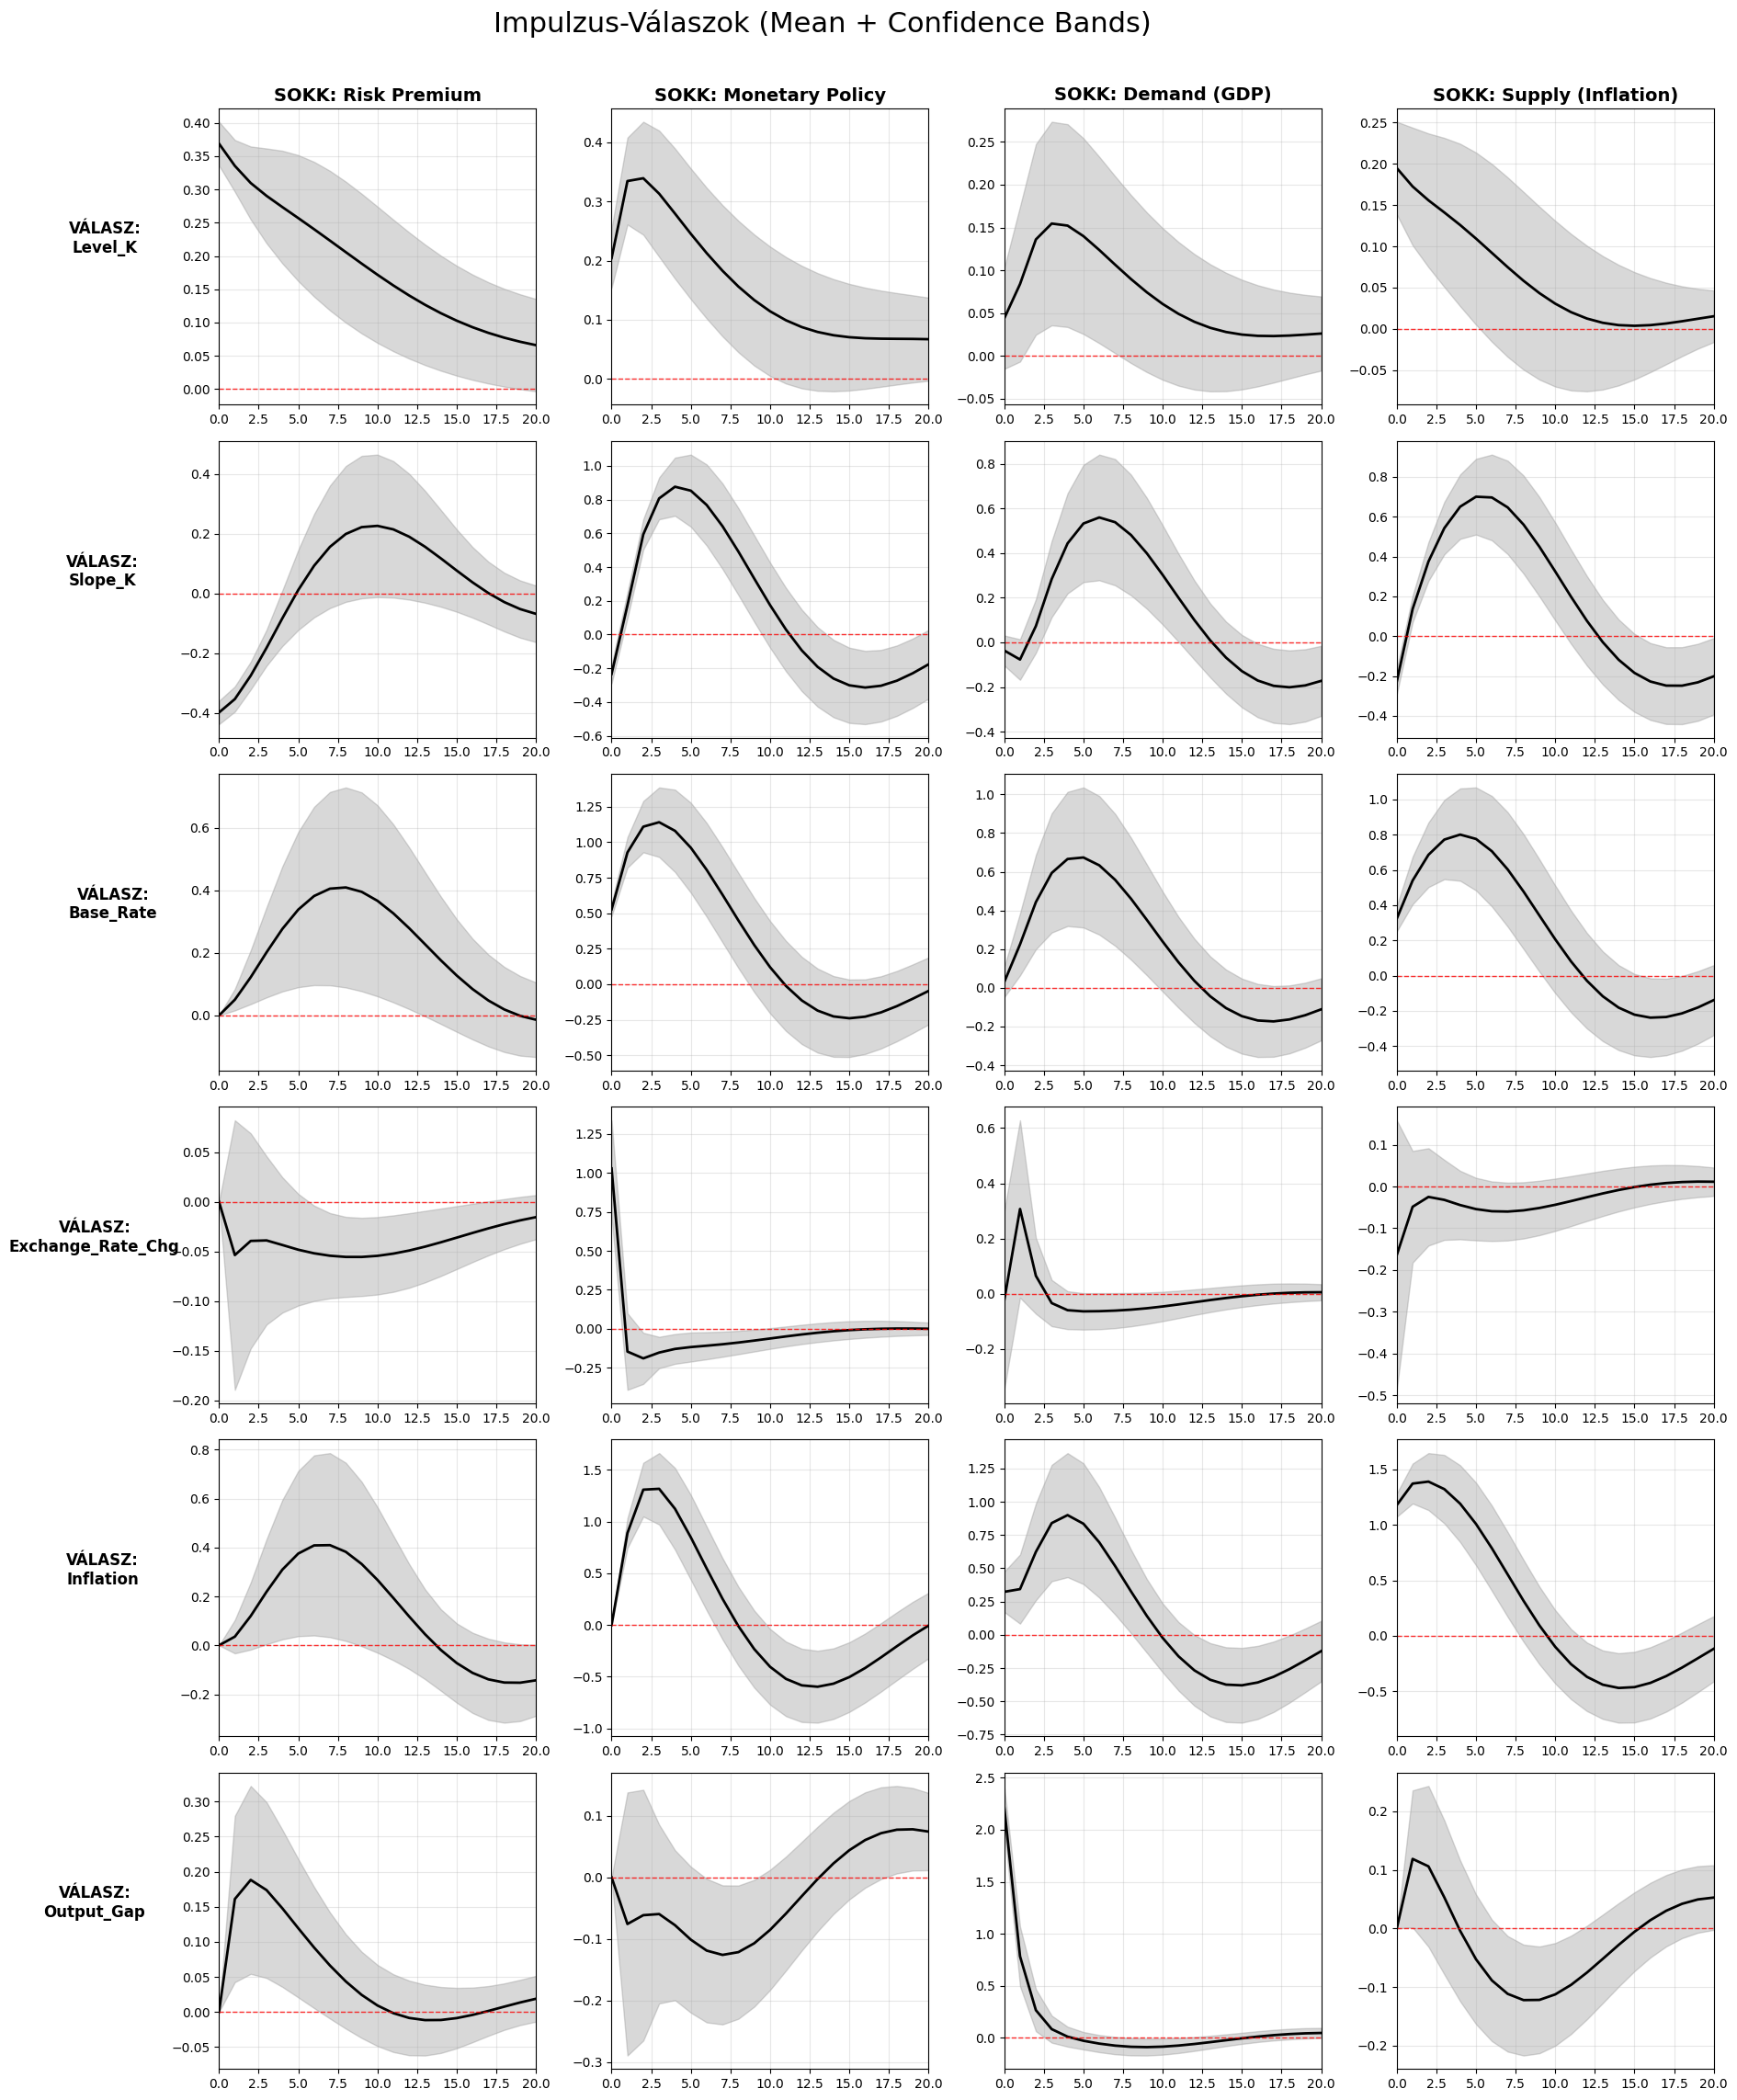

In [119]:
print("Impulzus-válaszok számítása és ábrázolása...")

# 1. IRF Számítása (Robusztus módszerrel)
periods = 20
irf_obj = results.irf(periods)

# Átlagos válasz (Ez általában stabil)
mean_irf = irf_obj.orth_irfs

# Hiba (Standard Error) számítása
# Megpróbáljuk az aszimptotikus módszert. Ha elhasal (NaN), akkor nullázzuk.
try:
    stderr_irf = irf_obj.stderr(orth=True)
    # Ha csupa NaN jön vissza (hiba), cseréljük nullára, hogy legalább a vonal látszódjon!
    if np.all(np.isnan(stderr_irf)):
        print("FIGYELEM: A standard hiba nem számítható (NaN). Csak az átlagot rajzoljuk.")
        stderr_irf = np.zeros_like(mean_irf)
    else:
        # A maradék NaN-okat is kiszedjük (biztos ami biztos)
        stderr_irf = np.nan_to_num(stderr_irf)
except:
    print("Hiba a szórás számításánál. Csak az átlagot rajzoljuk.")
    stderr_irf = np.zeros_like(mean_irf)

# 2. Változók megfeleltetése
# Ellenőrizzük, mi van a modellben
cols = var_data.columns.tolist()
shocks_map = {
    'Risk Premium':         'Level_K' if 'Level_K' in cols else ('Level_NS' if 'Level_NS' in cols else cols[-2]),
    'Monetary Policy':      'Base_Rate',
    'Demand (GDP)':         'Output_Gap',
    'Supply (Inflation)':   'Inflation'
}

# Sorrend (Válaszok)
response_vars = [v for v in ['Level_K', 'Slope_K', 'Level_NS', 'Slope_NS', 'Base_Rate', 'Exchange_Rate_Chg', 'Inflation', 'Output_Gap'] if v in cols]

# 3. Kirajzolás
fig, axes = plt.subplots(nrows=len(response_vars), ncols=4, figsize=(20, 4 * len(response_vars)))
fig.suptitle('Impulzus-Válaszok (Mean + Confidence Bands)', fontsize=22, y=0.95)

shock_names = list(shocks_map.keys())
shock_vars = list(shocks_map.values())

for row_idx, resp_var in enumerate(response_vars):
    for col_idx, shock_name in enumerate(shock_names):
        shock_var = shock_vars[col_idx]

        # Ha kevesebb a változó, mint a rács, kezeljük a hibát
        if row_idx >= len(axes): break
        ax = axes[row_idx, col_idx]

        try:
            impulse_idx = cols.index(shock_var)
            response_idx = cols.index(resp_var)

            # --- ADATOK ---
            # A statsmodels verziójától függően az indexelés lehet [idő, válasz, impulzus] vagy fordítva
            # A legbiztosabb: megnézzük az alakját
            if mean_irf.shape[0] == periods + 1:
                # Standard: (Idő, Válasz, Impulzus)
                series_mean = mean_irf[:, response_idx, impulse_idx]
                series_err = stderr_irf[:, response_idx, impulse_idx]
            else:
                # Fordított: (Válasz, Impulzus, Idő) - ritka, de előfordul
                series_mean = mean_irf[response_idx, impulse_idx, :]
                series_err = stderr_irf[response_idx, impulse_idx, :]

            # Konfidencia sávok (16-84%)
            upper = series_mean + series_err
            lower = series_mean - series_err

            # --- RAJZOLÁS ---
            # 1. Sáv (Ha van hiba)
            ax.fill_between(range(len(series_mean)), lower, upper, color='gray', alpha=0.3)

            # 2. Átlag (Fekete vonal) - Ennek most mindenképp látszódnia kell!
            ax.plot(series_mean, color='black', linewidth=2)

            # 3. Nulla vonal
            ax.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.8)

            # Címkék
            if row_idx == 0:
                ax.set_title(f"SOKK: {shock_name}", fontweight='bold', fontsize=14)
            if col_idx == 0:
                ax.set_ylabel(f"VÁLASZ:\n{resp_var}", fontweight='bold', rotation=0, labelpad=60, fontsize=12)

            ax.grid(True, alpha=0.3)
            ax.set_xlim(0, periods)

        except Exception as e:
            ax.text(0.5, 0.5, "N/A", ha='center', va='center')
            print(f"Hiba a {shock_var}->{resp_var} plotnál: {e}")

plt.tight_layout(rect=[0.05, 0, 1, 0.94])
plt.show()

In [120]:
# A modell illesztése után (results = model.fit(1)) futtasd ezt:

# A reziduálisok kovariancia mátrixának kinyerése
sigma_u = results.sigma_u

# Cholesky-felbontás (a sokkok ortogonalizálásához)
import numpy as np
P = np.linalg.cholesky(sigma_u)

# A sokkok mérete a főátlóban található
shock_sizes = np.diag(P)

# Kiíratás érthető formában
print("Sokk méretek (1 szórásnyi impulzus):")
for i, var in enumerate(results.names):
    print(f"{var}: {shock_sizes[i]:.4f}")

Sokk méretek (1 szórásnyi impulzus):
Output_Gap: 2.2233
Inflation: 1.1787
Base_Rate: 0.5267
Exchange_Rate_Chg: 2.3419
Level_K: 0.3688
Slope_K: 0.1296


In [121]:
# A modell által becsült (fitted) értékek kinyerése
# res_kf a mod_kf.fit() eredménye
predicted_yields = res_kf.fittedvalues.iloc[:, :9] # Csak a hozamok rész
actual_yields = combined_data.iloc[:, :9]

# Hibák kiszámítása (bázispontban, ha a hozamok %-ban vannak)
errors = (actual_yields - predicted_yields)

rmse = np.sqrt((errors**2).mean())
mae = errors.abs().mean()

print("--- ILLESZKEDÉS JÓSÁGA (Lejáratonként) ---")
for maturity, val in mae.items():
    print(f"{maturity}: {val:.4f} százalékpont (kb. {val*100:.1f} bp) átlagos hiba")

--- ILLESZKEDÉS JÓSÁGA (Lejáratonként) ---
M0.033: 0.8195 százalékpont (kb. 82.0 bp) átlagos hiba
M1: 0.7323 százalékpont (kb. 73.2 bp) átlagos hiba
M3: 0.7596 százalékpont (kb. 76.0 bp) átlagos hiba
M6: 0.7515 százalékpont (kb. 75.1 bp) átlagos hiba
M12: 0.7712 százalékpont (kb. 77.1 bp) átlagos hiba
M36: 0.9127 százalékpont (kb. 91.3 bp) átlagos hiba
M60: 0.7996 százalékpont (kb. 80.0 bp) átlagos hiba
M120: 0.6092 százalékpont (kb. 60.9 bp) átlagos hiba
M180: 0.5339 százalékpont (kb. 53.4 bp) átlagos hiba


In [122]:
# Statisztikai tesztek a maradványokra
# Ljung-Box teszt: Autokorreláció vizsgálata
# Jarque-Bera teszt: Normalitás vizsgálata
print(res_kf.summary())
# A summary táblázat alján keresd a "Ljung-Box (L1) (Q)" és "Jarque-Bera (JB)" sorokat.

                                                                                 Statespace Model Results                                                                                 
Dep. Variable:     ['M0.033', 'M1', 'M3', 'M6', 'M12', 'M36', 'M60', 'M120', 'M180', 'Output_Gap', 'Inflation', 'Base_Rate', 'Exchange_Rate_Chg']   No. Observations:                   64
Model:                                                                                                                            NelsonSiegelSSM   Log Likelihood                -991.252
Date:                                                                                                                            Fri, 16 Jan 2026   AIC                           2050.504
Time:                                                                                                                                    18:39:34   BIC                           2123.906
Sample:                                                          

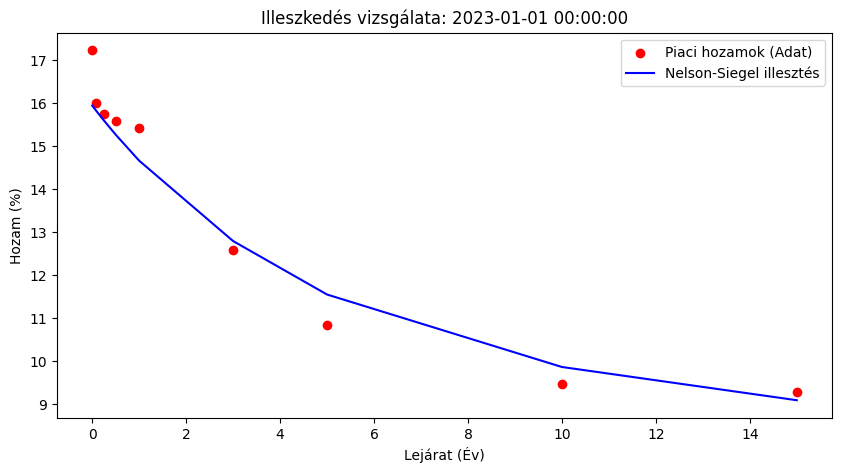

In [137]:
import matplotlib.pyplot as plt

def plot_fitted_curve(date_index):
    # Tényleges pontok
    actual = actual_yields.iloc[date_index]
    # Modell szerinti pontok
    fitted = predicted_yields.iloc[date_index]

    plt.figure(figsize=(10,5))
    plt.scatter(maturities_years, actual, color='red', label='Piaci hozamok (Adat)')
    plt.plot(maturities_years, fitted, color='blue', label='Nelson-Siegel illesztés')
    plt.title(f'Illeszkedés vizsgálata: {actual_yields.index[date_index]}')
    plt.xlabel('Lejárat (Év)')
    plt.ylabel('Hozam (%)')
    plt.legend()
    plt.show()

# Nézzük meg az utolsó negyedévet (2024 Q4)
plot_fitted_curve(-8)

In [124]:
from sklearn.metrics import r2_score
r2 = r2_score(actual_yields, predicted_yields)
print(f"Teljes hozamgörbe R-négyzet: {r2:.4f}")

Teljes hozamgörbe R-négyzet: 0.8158


In [138]:
def check_reppa_validation(results, steps=4):
    """
    Ellenőrzi, hogy a VAR modell impulzus-válaszai (IRF)
    megfelelnek-e a Reppa (2009) féle gazdasági elvárásoknak.
    """
    irf = results.irf(steps)
    # Az adatok sorrendje a var_data-ban:
    # ['Output_Gap', 'Inflation', 'Base_Rate', 'Exchange_Rate_Chg', 'Level_K', 'Slope_K']
    cols = list(results.names)

    validation_results = []

    # 1. Monetáris Politikai Sokk (Base_Rate emelés)
    # Elvárás: Kibocsátás (Output_Gap) ↓, Infláció ↓
    idx_br = cols.index('Base_Rate')
    idx_og = cols.index('Output_Gap')
    idx_inf = cols.index('Inflation')

    mp_og = irf.orth_irfs[1, idx_og, idx_br] # 1. negyedéves válasz
    mp_inf = irf.orth_irfs[1, idx_inf, idx_br]

    validation_results.append({
        "Sokk": "Monetáris Politika (Kamat ↑)",
        "Cél": "Output Gap ↓",
        "Érték": mp_og,
        "Státusz": "✅ Megfelel" if mp_og < 0 else "❌ Ellentmondás (Price Puzzle?)"
    })
    validation_results.append({
        "Sokk": "Monetáris Politika (Kamat ↑)",
        "Cél": "Infláció ↓",
        "Érték": mp_inf,
        "Státusz": "✅ Megfelel" if mp_inf < 0 else "❌ Ellentmondás"
    })

    # 2. Keresleti Sokk (Output_Gap ↑)
    # Elvárás: Infláció ↑
    dem_inf = irf.orth_irfs[1, idx_inf, idx_og]
    validation_results.append({
        "Sokk": "Keresleti Sokk (GDP ↑)",
        "Cél": "Infláció ↑",
        "Érték": dem_inf,
        "Státusz": "✅ Megfelel" if dem_inf > 0 else "❌ Ellentmondás"
    })

    # 3. Kockázati Prémium / Árfolyam Sokk (HUF gyengülés ↑)
    # Elvárás: Kamat (Base_Rate) ↑ (Jegybank védi a devizát)
    idx_er = cols.index('Exchange_Rate_Chg')
    prem_br = irf.orth_irfs[1, idx_br, idx_er]
    validation_results.append({
        "Sokk": "Kockázati Prémium (HUF gyengülés ↑)",
        "Cél": "Alapkamat ↑",
        "Érték": prem_br,
        "Státusz": "✅ Megfelel" if prem_br > 0 else "❌ Ellentmondás"
    })

    # Riport kiíratása
    df_val = pd.DataFrame(validation_results)
    print("\n=== REPPA (2009) ELŐJEL-MEGKÖTÉS VALIDÁCIÓ ===")
    display(df_val)
    return df_val

# Futtatás
validation_report = check_reppa_validation(results)


=== REPPA (2009) ELŐJEL-MEGKÖTÉS VALIDÁCIÓ ===


,Sokk,Cél,Érték,Státusz
0,Monetáris Politika (Kamat ↑),Output Gap ↓,-0.075709,✅ Megfelel
1,Monetáris Politika (Kamat ↑),Infláció ↓,0.889275,❌ Ellentmondás
2,Keresleti Sokk (GDP ↑),Infláció ↑,0.343690,✅ Megfelel
3,Kockázati Prémium (HUF gyengülés ↑),Alapkamat ↑,0.256282,✅ Megfelel


In [139]:
def run_structural_stress_test(var_results, scenario_type='PREM', magnitude=2.0):
    """
    Strukturális stresszteszt Reppa (2009) előjel-megkötései alapján.
    magnitude: Hány szórásnyi (standard deviation) legyen a sokk.
    """
    # Változók sorrendje a modelledben
    cols = list(var_results.names)
    n_vars = len(cols)

    # 1. Alapsokk vektor (kezdetben nulla)
    # A sokk irányát a Reppa-táblázat alapján adjuk meg
    shock_vector = np.zeros(n_vars)

    if scenario_type == 'PREM': # Kockázati prémium sokk (pl. válság)
        shock_vector[cols.index('Exchange_Rate_Chg')] = 1.0  # HUF gyengül
        shock_vector[cols.index('Inflation')] = 0.5          # Infláció nő (importált infl.)
        shock_vector[cols.index('Base_Rate')] = 0.8          # Jegybank kamatot emel védekezésül
        shock_vector[cols.index('Output_Gap')] = -0.5        # GDP visszaesik

    elif scenario_type == 'MP': # Szigorú Monetáris Politika
        shock_vector[cols.index('Base_Rate')] = 1.0          # Kamat fel
        shock_vector[cols.index('Inflation')] = -0.3         # Infláció le
        shock_vector[cols.index('Exchange_Rate_Chg')] = -0.5 # HUF erősödik

    # 2. A sokk skálázása a változók szórásával
    # Ez biztosítja, hogy a sokk "reális" mértékű legyen
    stds = np.sqrt(np.diag(var_results.sigma_u))
    final_shock = shock_vector * stds * magnitude

    # 3. Kivetítés a hozamgörbére (Impulse Response logika)
    # Megnézzük, hogy ez a kombinált sokk hogyan mozgatja meg a Level és Slope faktorokat
    # 4 negyedéves (1 éves) hatást nézünk
    forecast = var_results.forecast(var_results.endog[-1:], steps=4)

    # Hozzáadjuk a sokk hatását a jövőbeli értékekhez
    # (Egyszerűsített szemléltetés: a sokk azonnali hatása)
    print(f"=== {scenario_type} STRESSZTESZT EREDMÉNYE (Azonnali hatás) ===")
    for i, col in enumerate(cols):
        print(f"{col}: {final_shock[i]:.4f}")

    return final_shock

# Futtatás: Szimuláljunk egy 2-szórásnyi Kockázati Prémium sokkot (Válság forgatókönyv)
crisis_shock = run_structural_stress_test(results, scenario_type='PREM', magnitude=2.0)

=== PREM STRESSZTESZT EREDMÉNYE (Azonnali hatás) ===
Output_Gap: -2.2233
Inflation: 1.2222
Base_Rate: 0.9903
Exchange_Rate_Chg: 5.1264
Level_K: 0.0000
Slope_K: 0.0000


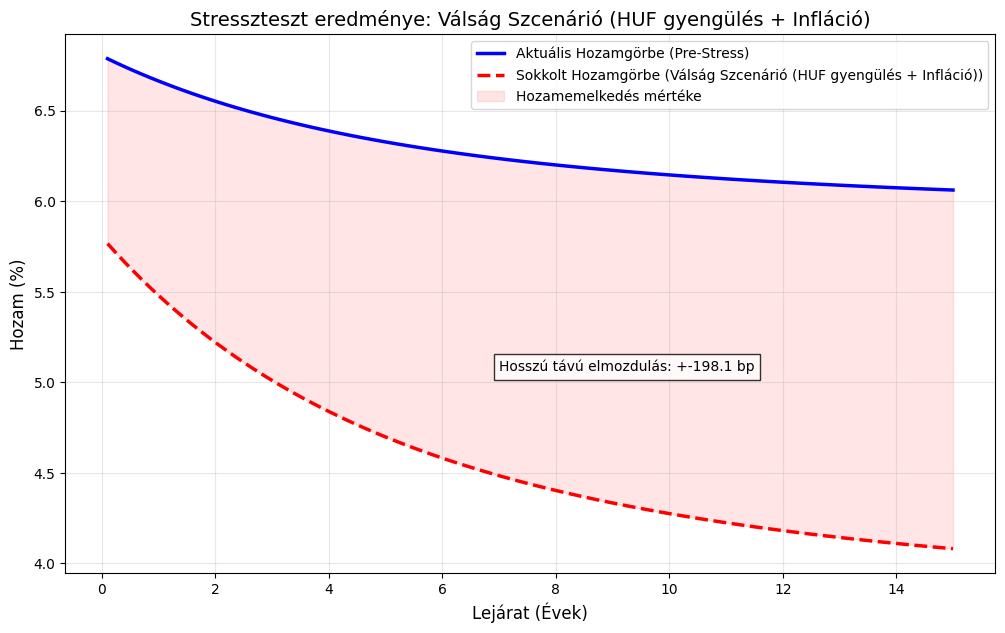

In [140]:
def plot_yield_curve_stress_test(res_kf, maturities_years, shock_vector, scenario_name="Kockázati Prémium Sokk"):
    """
    Kirajzolja az eredeti és a sokkolt hozamgörbe közötti különbséget.
    """
    # 1. Aktuális (utolsó ismert) faktorok kinyerése a Kálmán-szűrőből
    current_factors = res_kf.smoothed_state[:, -1]

    # 2. Sokkolt faktorok kiszámítása
    # A shock_vector tartalmazza a Level és Slope elmozdulását
    shocked_factors = current_factors.copy()
    shocked_factors[0] += shock_vector[0] # Level elmozdulás
    shocked_factors[1] += shock_vector[1] # Slope elmozdulás
    if len(current_factors) > 6: # Ha van Curvature
        shocked_factors[2] += shock_vector[2]

    # 3. Teljes görbe generálása (0-tól 15 évig, sűrű felbontással)
    plot_maturities = np.linspace(0.1, 15, 100)
    lmb = res_kf.params[-1] # A becsült lambda

    def get_ns_curve(factors, tau, lam):
        level, slope = factors[0], factors[1]
        s_loading = (1 - np.exp(-lam * tau)) / (lam * tau)
        yields = level + slope * s_loading
        if len(factors) > 6: # Curvature hozzáadása ha van
            c_loading = s_loading - np.exp(-lam * tau)
            yields += factors[2] * c_loading
        return yields

    curve_pre = get_ns_curve(current_factors, plot_maturities, lmb)
    curve_post = get_ns_curve(shocked_factors, plot_maturities, lmb)

    # 4. Ábrázolás
    plt.figure(figsize=(12, 7))
    plt.plot(plot_maturities, curve_pre, label='Aktuális Hozamgörbe (Pre-Stress)', color='blue', linewidth=2.5)
    plt.plot(plot_maturities, curve_post, label=f'Sokkolt Hozamgörbe ({scenario_name})', color='red', linestyle='--', linewidth=2.5)

    # Kitöltés a két görbe között a vizuális hatás kedvéért
    plt.fill_between(plot_maturities, curve_pre, curve_post, color='red', alpha=0.1, label='Hozamemelkedés mértéke')

    plt.title(f'Stresszteszt eredménye: {scenario_name}', fontsize=14)
    plt.xlabel('Lejárat (Évek)', fontsize=12)
    plt.ylabel('Hozam (%)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Szöveges összefoglaló az ábrán
    shift_long = curve_post[-1] - curve_pre[-1]
    plt.text(7, curve_pre[-1]-1, f"Hosszú távú elmozdulás: +{shift_long*100:.1f} bp",
             bbox=dict(facecolor='white', alpha=0.8), fontsize=10)

    plt.show()

# Futtatás az előzőleg kiszámolt crisis_shock-al
plot_yield_curve_stress_test(res_kf, maturities_years, crisis_shock, scenario_name="Válság Szcenárió (HUF gyengülés + Infláció)")